In [149]:

"""
    포함된 함수 정보
    
    사용법 익혀서 사용하시면 더 편리합니다!!! feedback은 언제든 환영!!
    
    getSpecifiedWeatherData : 명시한 station의 weather 데이터만 리턴한다.
    
    isThereNoneData : Missing data, Trace data의 개수정보를 받아서 만든 dataframe을 리턴한다.
    
    remove_m_row : M, -이 포함된 row는 drop하고, T는 0으로 변경한 dataframe을 리턴한다.
    
    divideIntoNumericAndCategoricalVariables : 컬럼을 확인해서 numerical_features와 categorical_features을 나누는 작업을 해준다.
    
    saveDataFrameToCsv : 넘겨준 df를 filename + 년월일시간분 의 format으로 이루어진 이름의 파일로 생성해준다.
    
    sendSlackDm : slack msg보내는 function
"""

from datetime import datetime
import pandas as pd
import json
import requests
import numpy as np

def getSpecifiedWeatherData(df, station_nbr):
    """
        df와 station_nbr를 받는다.
    """
    return df[df["station_nbr"] == station_nbr].reset_index(drop=True)

def isThereNoneData(df, percentage=60):
    """
        Missing data, Trace data, - data의 개수정보를 받아서 만든 dataframe을 리턴한다.
        패러미터는 df와, 상기된 데이터들이 해당 컬럼에서 차지한 percentage정도를 출력하고싶을때 입력한다. 
        default는 60% 이상인 컬럼명을 출력한다.
    """
    columns = ["Column", "Row Count", "Missing Data", "M Data %", "Trace Data", "T Data %", "Bar Data", "B Data %"]
    li = list(df.columns)
    m_count_li = []
    t_count_li = []
    b_count_li = []    
    row_count_li = []
    m_percent_li = []
    t_percent_li = []
    b_percent_li = []
    for l in li:
        m_count = 0
        t_count = 0
        b_count = 0
        for i, contents in enumerate(df[l]):
            contents = str(contents)
            if(contents.strip() == "M"):
                m_count += 1
            if(contents.strip() == "T"):
                t_count += 1
            if(contents.strip() == "-"):
                b_count += 1            
        m_count_li.append(m_count)
        t_count_li.append(t_count)
        b_count_li.append(b_count)
        row_count_li.append(len(df[l]))
        m_percent_li.append(round(m_count/len(df[l])*100, 2))
        t_percent_li.append(round(t_count/len(df[l])*100, 2))
        b_percent_li.append(round(b_count/len(df[l])*100, 2))
    result_df = pd.DataFrame({
        "Column" : li, 
        "Row Count" : row_count_li,
        "Missing Data" : m_count_li, 
        "M Data %" : m_percent_li,
        "Trace Data" : t_count_li, 
        "T Data %": t_percent_li,
        "Bar Data" : b_count_li, 
        "B Data %" : b_percent_li}, 
         columns=columns) 
    
    for column in ["M Data %", "T Data %", "B Data %"]:
        print("{} over {}% : {}".format(" ".join(column.split(" ")[:-1]), \
                                        percentage, list(result_df["Column"][result_df[column] >= percentage])))
    return result_df

def changeTypeToInt(a):
    temp = str(a).strip()
    if temp == 'M' or temp == '-':
        return np.nan
    else:
        return int(a)
    
def changeTypeToFloat(a):
    temp = str(a).strip()
    if temp == 'M' or temp == '-':
        return np.nan
    elif temp == 'T':
        return 0
    else:
        return float(a)
    
def remove_m_row(df, columns = [], print_msg = True):
    """
        m_row를 제거할 data_frame 파일을 df 패러미터로 넣어준다.
        columns를 패러미터로 안넣어줄 경우에는 전체 컬럼의 m값을 날린다.
        columns를 넣어주는 경우에는 반드시 리스트로 넣어줄것!! 예:) ["tmax", "tmin"]
        그리고 처리된 df를 리턴하는 것이므로!! 원하는 변수명으로 받아줄 것
        print_msg 값은 False로 넣어주면 보고서는 안나오도록 처리했고, default는 true입니다.
        예:) df_test = remove_m_row(df_weather, ["tmax", "tmin"])
    """
    result_df = df.copy()
    if len(columns) == 0:
        columns = result_df.columns
    cols_int = ["tmax", "tmin", "tavg", "dewpoint", "wetbulb", "heat", "cool", "sunrise", "sunset"]
    cols_float = ["snowfall", "preciptotal", "stnpressure", "sealevel", "depart", "resultspeed", "resultdir", "avgspeed"]
    
    process_int = []
    process_float = []
    for column in columns:
        if column in cols_int:
            process_int.append(column)
            result_df[column] = result_df[column].apply(changeTypeToInt)
        elif column in cols_float:
            process_float.append(column)
            result_df[column] = result_df[column].apply(changeTypeToFloat)

    result_df = result_df.dropna()

    if print_msg:
        print("원본 데이터프레임 length : " + str(len(df)))
        print("제거하고 싶은 컬럼 : " + str(list(columns)))
        print("제거한 int 컬럼 : " + str(process_int))
        print("제거한 float 컬럼 : " + str(process_float))
        print("제거한 후 데이터프레임 length : " + str(len(result_df)))
        
    return result_df

def remove_columns(df, columns = [], print_msg = True):
    """
        data_frame 파일을 df 패러미터로 넣어준다.
        columns에 제거하고싶은 columns를 리스트형식으로 넣어준다.
    """
    for column in columns:
        df.drop(column, axis=1, inplace=True)
        
    if print_msg:
        print("제거한 컬럼명 : " + str(list(columns)))
        
    return df.tail()

def divideIntoNumericAndCategoricalVariables(df):
    """
        컬럼을 확인해서 numerical_features와 categorical_features을 나누는 작업을 해준다.
        데이터 분석하기전에 확인하면 좋은 함수. 패러미터는 df를 넣어주면 된다.
    """
    numerical_features = []
    categorical_features = []
    for f in df.columns:
        if df.dtypes[f] != 'object':
            numerical_features.append(f)
        else:
            categorical_features.append(f)
    print("Numerical Features Qty :", len(numerical_features),"\n")
    print("Numerical Features : ", numerical_features, "\n\n")
    print("Categorical Features Qty :", len(categorical_features),"\n")
    print("Categorical Features :", categorical_features)
    return numerical_features, categorical_features

def saveDataFrameToCsv(df, fileName, idx = False):
    """
        넘겨준 df를 filename + 년월일시간분 의 format으로 이루어진 이름의 파일로 생성해준다.
        index를 True로 넘겨주면 저장할 때 아규먼트로 index=True를 넣어주게 된다.
    """
    fileName += "_" + datetime.now().strftime("%Y%m%d%H%M") + ".csv"
    return df.to_csv(fileName, index = idx)

def sendSlackDm(url, text):
    """
        Parameter :
            각자 받은 url을 넣어준다.
            text에는 보낼 글 내용
    """
    webhook_url = url
    slack_data = {'text': text}
    response = requests.post(
        webhook_url,
        data=json.dumps(slack_data),
        headers={'Content-Type': 'application/json'}
    )
    if response.status_code != 200:
        raise ValueError(
            'Request to slack returned an error %s, the response is:\n%s'%(response.status_code, response.text)
    )

In [152]:
# Importing Libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings 
import warnings
warnings.filterwarnings('ignore')

# Loading Dataset
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")
key = pd.read_csv("../Data/key.csv")
submission_example = pd.read_csv("../Data/sampleSubmission.csv")
weather = pd.read_csv("../Data/weather.csv")


In [153]:
# Adding station_nbr to train data
station_nbr = key.loc[train["store_nbr"]-1]["station_nbr"]
station_nbr = pd.DataFrame(station_nbr)
station_nbr.reset_index(inplace = True, drop=True)
df = pd.concat([train, station_nbr] , axis = 1 , join = 'inner' )
df["date"] = pd.to_datetime(df["date"])

In [154]:
# successfully merged! 
df.tail()

,date,store_nbr,item_nbr,units,station_nbr
4617595,2014-10-31,45,107,0,16
4617596,2014-10-31,45,108,0,16
4617597,2014-10-31,45,109,0,16
4617598,2014-10-31,45,110,0,16
4617599,2014-10-31,45,111,0,16


In [155]:
# Adding weather to df 
weather["date"] = pd.to_datetime(weather["date"])
df = pd.merge(df, weather)

In [156]:
df.tail()

,date,store_nbr,item_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,...,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
4617595,2014-10-31,39,107,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617596,2014-10-31,39,108,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617597,2014-10-31,39,109,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617598,2014-10-31,39,110,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617599,2014-10-31,39,111,2,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1


In [225]:
# Station 16 - Dealing with missing data
# get rid of column depart , snowfall , sunrise, sunset 
station_16 = getSpecifiedWeatherData(weather, station_nbr=16)
isThereNoneData(station_16, percentage=60)

M Data over 60% : ['depart', 'snowfall']
T Data over 60% : []
B Data over 60% : ['sunrise', 'sunset']


,Column,Row Count,Missing Data,M Data %,Trace Data,T Data %,Bar Data,B Data %
0,station_nbr,1035,0,0.00,0,0.00,0,0.0
1,date,1035,0,0.00,0,0.00,0,0.0
2,tmax,1035,7,0.68,0,0.00,0,0.0
3,tmin,1035,7,0.68,0,0.00,0,0.0
4,tavg,1035,13,1.26,0,0.00,0,0.0
5,depart,1035,1035,100.00,0,0.00,0,0.0
6,dewpoint,1035,8,0.77,0,0.00,0,0.0
7,wetbulb,1035,11,1.06,0,0.00,0,0.0
8,heat,1035,13,1.26,0,0.00,0,0.0
9,cool,1035,13,1.26,0,0.00,0,0.0


In [226]:
# drop depart and snowfall column 
remove_columns(station_16 , columns= ['snowfall', 'depart', 'sunrise', 'sunset'])
station_16.head()

제거한 컬럼명 : ['snowfall', 'depart', 'sunrise', 'sunset']


,station_nbr,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,16,2012-01-01,50,30,40,37,40,25,0,RA MIFG BR,T,29.80,29.89,4.2,21,6.8
1,16,2012-01-02,50,30,40,26,35,25,0,RA,0.01,29.48,29.59,9.6,27,10.9
2,16,2012-01-03,32,11,22,6,18,43,0,,0.00,29.70,29.84,10.2,31,10.9
3,16,2012-01-04,27,8,18,-1,14,47,0,,0.00,29.90,30.00,7.9,28,9.9
4,16,2012-01-05,38,24,31,13,25,34,0,,0.00,29.70,29.82,6.9,27,8.1


In [227]:
# get rid of rows with missing values and replace T with 0
station_16 = remove_m_row(station_16)

원본 데이터프레임 length : 1035
제거하고 싶은 컬럼 : ['station_nbr', 'date', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool', 'codesum', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
제거한 int 컬럼 : ['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool']
제거한 float 컬럼 : ['preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
제거한 후 데이터프레임 length : 1016


In [228]:
station_16.drop('station_nbr',axis =1, inplace = True)
station_16.head()

,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2012-01-01,50.0,30.0,40.0,37.0,40.0,25.0,0.0,RA MIFG BR,0.00,29.80,29.89,4.2,21.0,6.8
1,2012-01-02,50.0,30.0,40.0,26.0,35.0,25.0,0.0,RA,0.01,29.48,29.59,9.6,27.0,10.9
2,2012-01-03,32.0,11.0,22.0,6.0,18.0,43.0,0.0,,0.00,29.70,29.84,10.2,31.0,10.9
3,2012-01-04,27.0,8.0,18.0,-1.0,14.0,47.0,0.0,,0.00,29.90,30.00,7.9,28.0,9.9
4,2012-01-05,38.0,24.0,31.0,13.0,25.0,34.0,0.0,,0.00,29.70,29.82,6.9,27.0,8.1


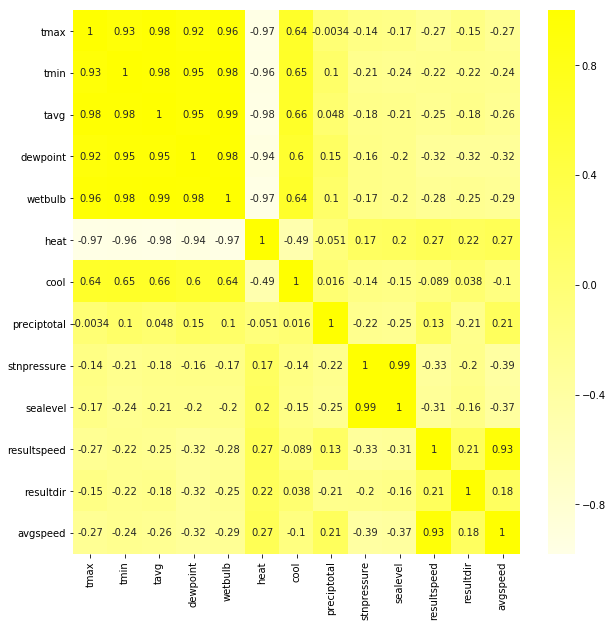

In [229]:
# Station 16 heatmap 
cols = station_16.columns
plt.figure(figsize = (10,10))
cmap = sns.light_palette("yellow", as_cmap=True) # 위에 한번만 선언하면 됨
sns.heatmap(station_16[cols].corr(), annot=True, cmap=cmap)
plt.show()

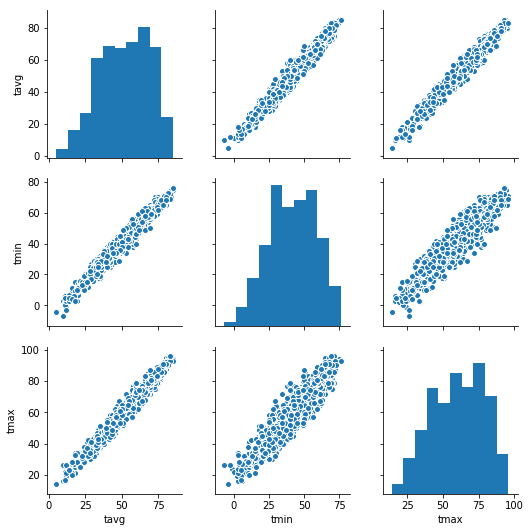

In [177]:
# Station 16 : tmax, tmin, tavg
# tmin, tavg, tmax are highly correlated 
import seaborn as sns 
import matplotlib.pyplot as plt

cols = ["tavg", "tmin", "tmax"]
sns.pairplot(station_16[cols])
plt.show()

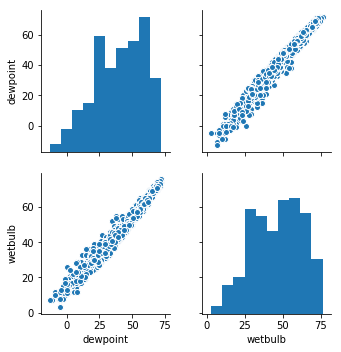

In [178]:
# Station 16 : dewpoint, wetbulb, sunrise, sunset
cols = ["dewpoint", "wetbulb"]
sns.pairplot(station_16[cols])
plt.show()

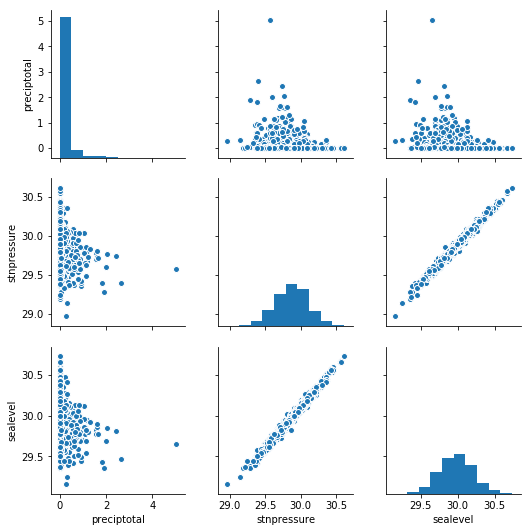

In [181]:
# Station 16: snowfall, preciptotal, stnpressure, sealevel
# stnpressure and sealevel are highly correlated 
cols = ["preciptotal", "stnpressure", "sealevel"]
sns.pairplot(station_16[cols])
plt.show()

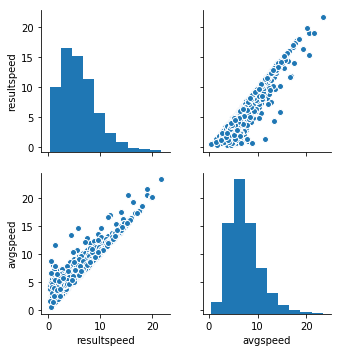

In [182]:
# Station 16: resultspeed, avgspeed
# resultspeed and avg speed are highly correlated 
cols = ["resultspeed", "avgspeed"]
sns.pairplot(station_16[cols])
plt.show()

In [394]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(station_16.values, i) for i in range(station_16.shape[1])]
vif["features"] = station_16.columns
vif.sort_values('VIF Factor').reset_index(drop = True)

,VIF Factor,features
0,1.404600,preciptotal
1,1.611082,resultdir
2,8.313653,resultspeed
3,9.139003,avgspeed
4,87.607429,dewpoint
5,103.544902,sealevel
6,104.427238,stnpressure
7,125.687515,cool
8,290.622435,wetbulb
9,1186.982427,tmin


In [331]:
# Station 17 
station_17 = getSpecifiedWeatherData(weather, station_nbr=17)
isThereNoneData(station_17, percentage=60)


M Data over 60% : ['depart']
T Data over 60% : []
B Data over 60% : ['sunrise', 'sunset']


,Column,Row Count,Missing Data,M Data %,Trace Data,T Data %,Bar Data,B Data %
0,station_nbr,1035,0,0.00,0,0.00,0,0.0
1,date,1035,0,0.00,0,0.00,0,0.0
2,tmax,1035,1,0.10,0,0.00,0,0.0
3,tmin,1035,1,0.10,0,0.00,0,0.0
4,tavg,1035,5,0.48,0,0.00,0,0.0
5,depart,1035,1035,100.00,0,0.00,0,0.0
6,dewpoint,1035,1,0.10,0,0.00,0,0.0
7,wetbulb,1035,9,0.87,0,0.00,0,0.0
8,heat,1035,5,0.48,0,0.00,0,0.0
9,cool,1035,5,0.48,0,0.00,0,0.0


In [332]:
remove_columns(station_17 , columns= ['depart','sunrise','sunset'])
station_17.head()

제거한 컬럼명 : ['depart', 'sunrise', 'sunset']


,station_nbr,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,17,2012-01-01,56,38,47,23,37,18,0,,0.0,0.00,29.83,30.50,5.4,32,5.8
1,17,2012-01-02,45,22,34,10,28,31,0,,0.0,0.00,29.96,30.66,3.7,33,4.8
2,17,2012-01-03,55,19,37,18,31,28,0,,0.0,0.00,29.61,30.36,6.9,18,7.0
3,17,2012-01-04,63,28,46,25,36,19,0,RA,0.0,T,29.59,30.29,2.1,36,3.3
4,17,2012-01-05,68,26,47,26,38,18,0,,0.0,0.00,29.42,30.14,4.3,20,4.4


In [333]:
station_17.drop('station_nbr',axis =1, inplace = True)
station_17.head()

,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2012-01-01,56,38,47,23,37,18,0,,0.0,0.00,29.83,30.50,5.4,32,5.8
1,2012-01-02,45,22,34,10,28,31,0,,0.0,0.00,29.96,30.66,3.7,33,4.8
2,2012-01-03,55,19,37,18,31,28,0,,0.0,0.00,29.61,30.36,6.9,18,7.0
3,2012-01-04,63,28,46,25,36,19,0,RA,0.0,T,29.59,30.29,2.1,36,3.3
4,2012-01-05,68,26,47,26,38,18,0,,0.0,0.00,29.42,30.14,4.3,20,4.4


In [334]:
station_17 = remove_m_row(station_17)

원본 데이터프레임 length : 1035
제거하고 싶은 컬럼 : ['date', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool', 'codesum', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
제거한 int 컬럼 : ['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool']
제거한 float 컬럼 : ['snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
제거한 후 데이터프레임 length : 962


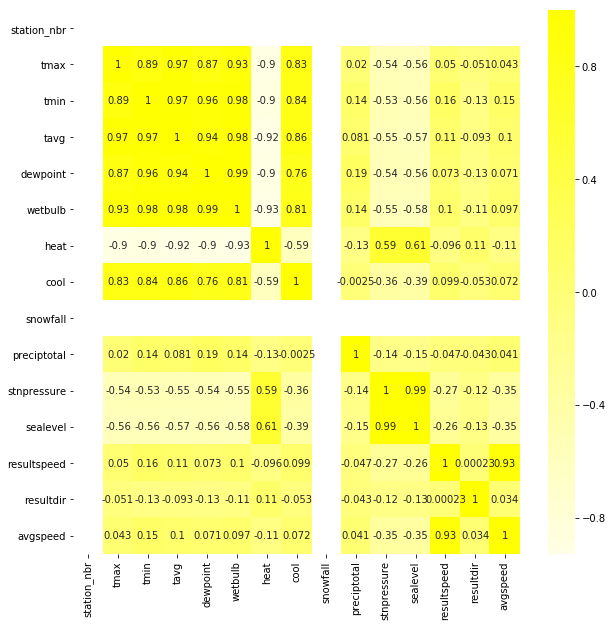

In [275]:
# Station 17 : heatmap
cols_17 = station_17.columns
plt.figure(figsize = (10,10))
cmap = sns.light_palette("yellow", as_cmap=True) # 위에 한번만 선언하면 됨
sns.heatmap(station_17[cols_17].corr(), annot=True, cmap=cmap)
plt.show()

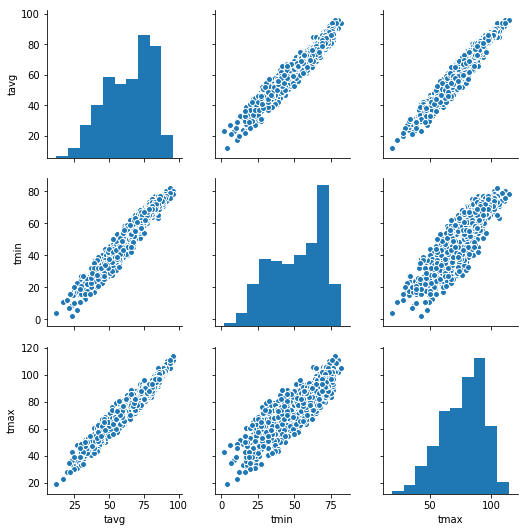

In [276]:
# Station 17 : tmax, tmin, tavg
cols = ["tavg", "tmin", "tmax"]
sns.pairplot(station_17[cols])
plt.show()

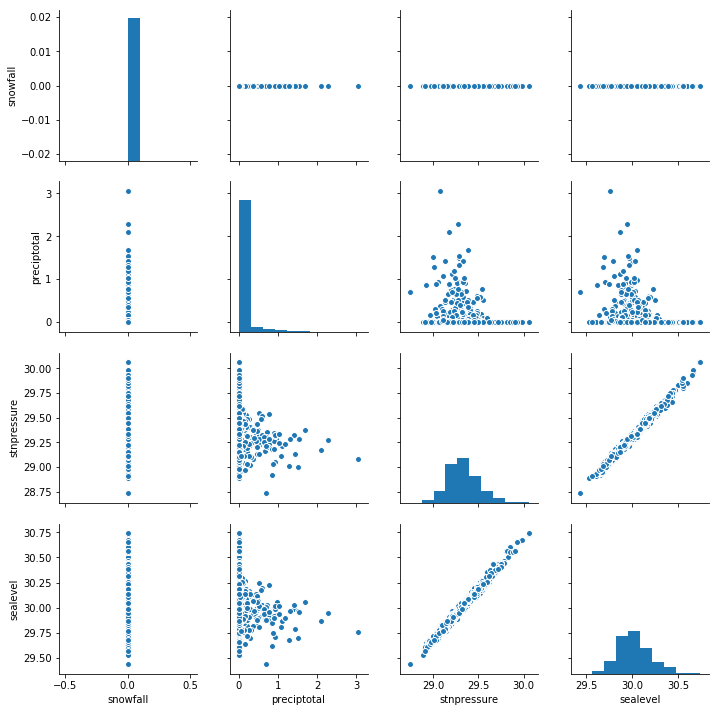

In [277]:
# Station 17 : snowfall, preciptotal, stnpressure, sealevel
cols = ["snowfall", "preciptotal", "stnpressure", "sealevel"]
sns.pairplot(station_17[cols])
plt.show()

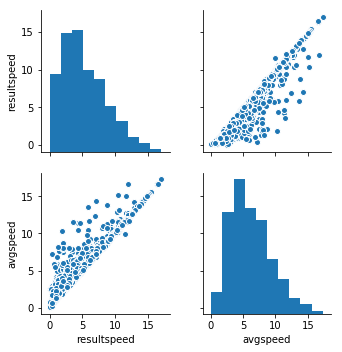

In [278]:
# Station 17 : resultspeed, avgspeed
cols = ["resultspeed", "avgspeed"]
sns.pairplot(station_17[cols])
plt.show()

In [393]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(station_17.values, i) for i in range(station_17.shape[1])]
vif["features"] = station_17.columns
vif.sort_values('VIF Factor').reset_index(drop = True)

,VIF Factor,features
0,1.123964,resultdir
1,1.218058,preciptotal
2,9.572922,resultspeed
3,10.144379,avgspeed
4,98.506246,stnpressure
5,98.662198,dewpoint
6,104.677991,sealevel
7,260.636858,wetbulb
8,1234.971854,tmax
9,1348.259878,tmin


In [268]:
# Station18
station_18 = getSpecifiedWeatherData(weather, station_nbr=18)
isThereNoneData(station_18, percentage=60)

M Data over 60% : []
T Data over 60% : []
B Data over 60% : []


,Column,Row Count,Missing Data,M Data %,Trace Data,T Data %,Bar Data,B Data %
0,station_nbr,1035,0,0.00,0,0.00,0,0.0
1,date,1035,0,0.00,0,0.00,0,0.0
2,tmax,1035,2,0.19,0,0.00,0,0.0
3,tmin,1035,2,0.19,0,0.00,0,0.0
4,tavg,1035,4,0.39,0,0.00,0,0.0
5,depart,1035,34,3.29,0,0.00,0,0.0
6,dewpoint,1035,0,0.00,0,0.00,0,0.0
7,wetbulb,1035,3,0.29,0,0.00,0,0.0
8,heat,1035,4,0.39,0,0.00,0,0.0
9,cool,1035,4,0.39,0,0.00,0,0.0


In [269]:
station_18.drop('station_nbr',axis =1, inplace = True)
station_18.head()

,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2012-01-01,59,40,50,4,28,40,15,0,0730,1732,,0.0,0.00,29.98,30.49,9.0,33,8.9
1,2012-01-02,53,35,44,-2,23,36,21,0,0730,1733,,0.0,0.00,30.11,30.63,6.7,35,6.9
2,2012-01-03,59,30,45,0,25,37,20,0,0730,1734,,0.0,0.00,29.84,30.41,8.8,17,9.1
3,2012-01-04,62,37,50,5,33,41,15,0,0730,1734,,0.0,0.00,29.75,30.28,0.8,15,5.5
4,2012-01-05,66,35,51,6,33,42,14,0,0731,1735,,0.0,0.00,29.66,30.21,2.7,18,2.9


In [279]:
station_18=remove_m_row(station_18)

원본 데이터프레임 length : 1035
제거하고 싶은 컬럼 : ['date', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
제거한 int 컬럼 : ['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset']
제거한 float 컬럼 : ['depart', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
제거한 후 데이터프레임 length : 993


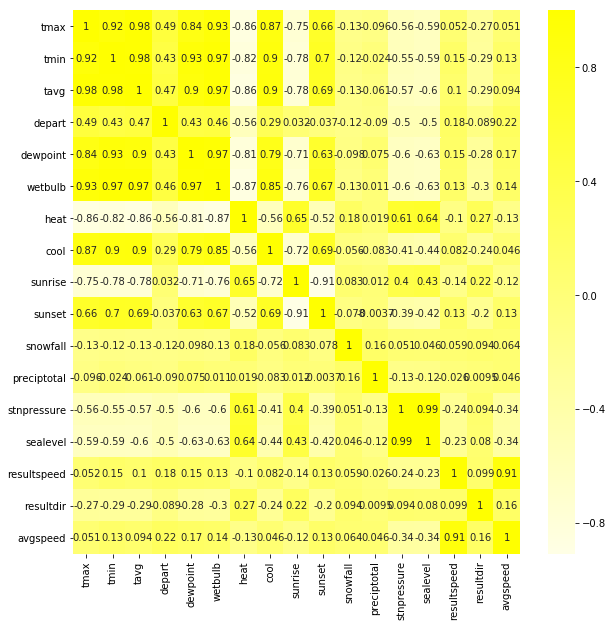

In [280]:
cols = station_18.columns
plt.figure(figsize = (10,10))
cmap = sns.light_palette("yellow", as_cmap=True) # 위에 한번만 선언하면 됨
sns.heatmap(station_18[cols].corr(), annot=True, cmap=cmap)
plt.show()

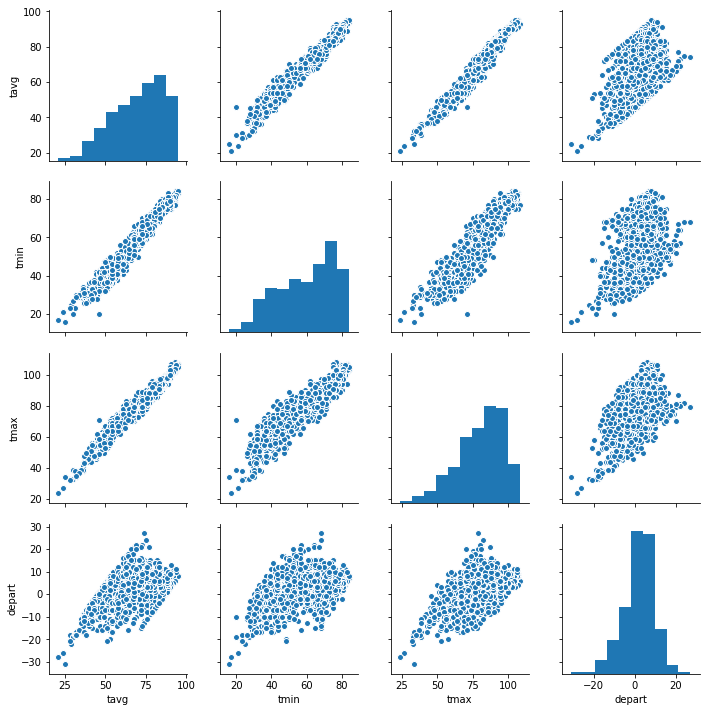

In [282]:
# Station 18 : tmax, tmin, tavg, depart
cols = ["tavg", "tmin", "tmax", "depart"]
sns.pairplot(station_18[cols])
plt.show()

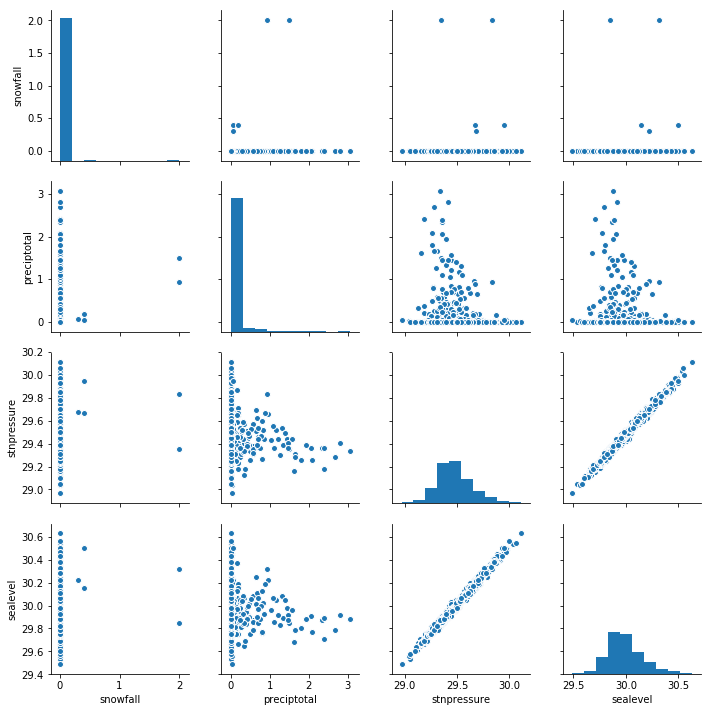

In [283]:
# Station 18 : snowfall, preciptotal, stnpressure, sealevel
cols = ["snowfall", "preciptotal", "stnpressure", "sealevel"]
sns.pairplot(station_18[cols])
plt.show()

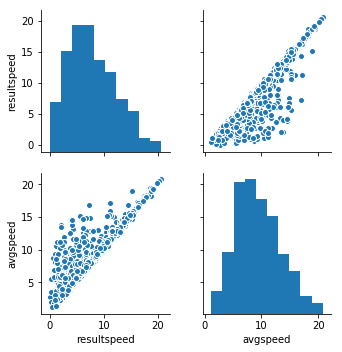

In [284]:
# Station 18 : resultspeed, avgspeed
cols = ["resultspeed", "avgspeed"]
sns.pairplot(station_18[cols])
plt.show()

In [339]:
station_18.head()

,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2012-01-01,59.0,40.0,50.0,4.0,28,40.0,15.0,0.0,730.0,1732.0,,0.0,0.0,29.98,30.49,9.0,33.0,8.9
1,2012-01-02,53.0,35.0,44.0,-2.0,23,36.0,21.0,0.0,730.0,1733.0,,0.0,0.0,30.11,30.63,6.7,35.0,6.9
2,2012-01-03,59.0,30.0,45.0,0.0,25,37.0,20.0,0.0,730.0,1734.0,,0.0,0.0,29.84,30.41,8.8,17.0,9.1
3,2012-01-04,62.0,37.0,50.0,5.0,33,41.0,15.0,0.0,730.0,1734.0,,0.0,0.0,29.75,30.28,0.8,15.0,5.5
4,2012-01-05,66.0,35.0,51.0,6.0,33,42.0,14.0,0.0,731.0,1735.0,,0.0,0.0,29.66,30.21,2.7,18.0,2.9


In [392]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(station_18.values, i) for i in range(station_18.shape[1])]
vif["features"] = station_18.columns
vif.sort_values('VIF Factor').reset_index(drop = True)

,VIF Factor,features
0,1.103061,snowfall
1,1.208391,preciptotal
2,1.258203,resultdir
3,4.092051,depart
4,6.719493,sunset
5,7.253907,resultspeed
6,7.932882,avgspeed
7,13.289941,sunrise
8,71.880881,dewpoint
9,113.320944,stnpressure


In [381]:
# Station 19
station_19 = getSpecifiedWeatherData(weather, station_nbr=19)
isThereNoneData(station_19, percentage=60)

M Data over 60% : []
T Data over 60% : []
B Data over 60% : []


,Column,Row Count,Missing Data,M Data %,Trace Data,T Data %,Bar Data,B Data %
0,station_nbr,1035,0,0.00,0,0.00,0,0.0
1,date,1035,0,0.00,0,0.00,0,0.0
2,tmax,1035,2,0.19,0,0.00,0,0.0
3,tmin,1035,2,0.19,0,0.00,0,0.0
4,tavg,1035,8,0.77,0,0.00,0,0.0
5,depart,1035,38,3.67,0,0.00,0,0.0
6,dewpoint,1035,11,1.06,0,0.00,0,0.0
7,wetbulb,1035,49,4.73,0,0.00,0,0.0
8,heat,1035,8,0.77,0,0.00,0,0.0
9,cool,1035,8,0.77,0,0.00,0,0.0


In [382]:
remove_columns(station_19 , columns= ['depart','sunrise','sunset'])


제거한 컬럼명 : ['depart', 'sunrise', 'sunset']


,station_nbr,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
1030,19,2014-10-27,75,52,64,52,57,1,0,,0.0,0.04,28.87,29.64,10.0,19,11.1
1031,19,2014-10-28,67,48,58,38,47,7,0,RA,0.0,T,29.08,29.80,14.2,26,14.6
1032,19,2014-10-29,49,36,43,32,40,22,0,,0.0,T,29.32,30.04,9.6,30,10.1
1033,19,2014-10-30,51,32,42,33,40,23,0,RA,0.0,T,29.31,30.08,5.5,27,6.0
1034,19,2014-10-31,45,33,39,24,32,26,0,RA SN,0.1,0.02,29.51,30.24,20.4,34,20.9


In [383]:
station_19=remove_m_row(station_19)

원본 데이터프레임 length : 1035
제거하고 싶은 컬럼 : ['station_nbr', 'date', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool', 'codesum', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
제거한 int 컬럼 : ['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool']
제거한 float 컬럼 : ['snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
제거한 후 데이터프레임 length : 978


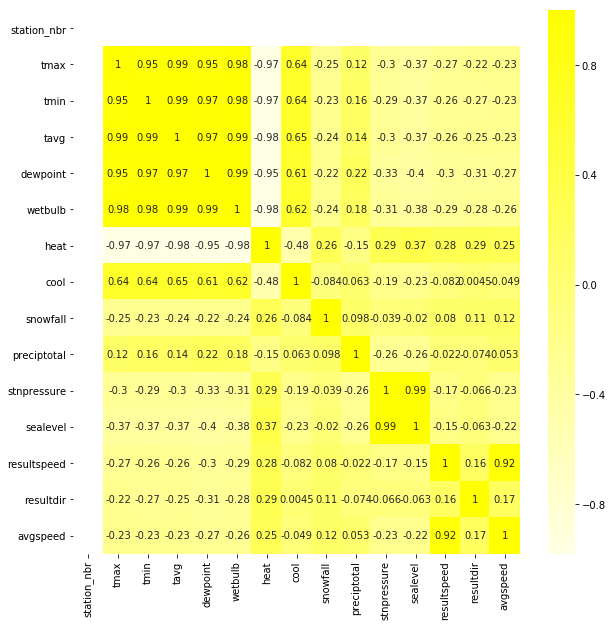

In [384]:
cols = station_19.columns
plt.figure(figsize = (10,10))
cmap = sns.light_palette("yellow", as_cmap=True) # 위에 한번만 선언하면 됨
sns.heatmap(station_19[cols].corr(), annot=True, cmap=cmap)
plt.show()

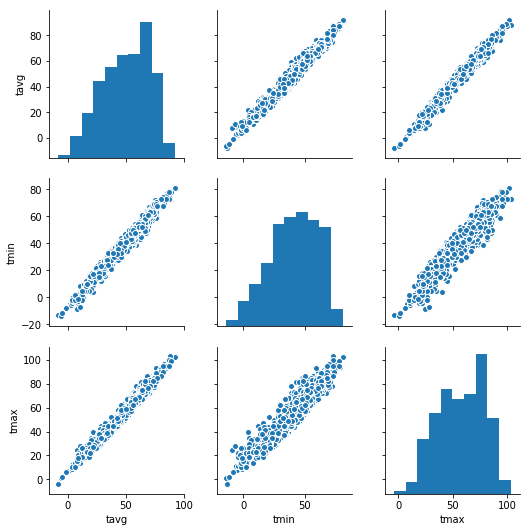

In [385]:
# Station 19 : tmax, tmin, tavg, depart
cols = ["tavg", "tmin", "tmax"]
sns.pairplot(station_19[cols])
plt.show()

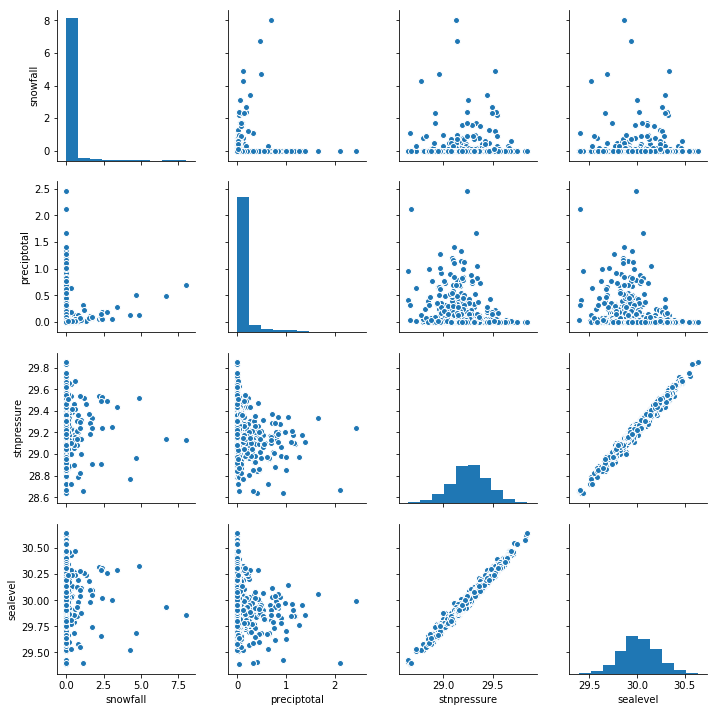

In [386]:
# Station 19 : snowfall, preciptotal, stnpressure, sealevel
cols = ["snowfall", "preciptotal", "stnpressure", "sealevel"]
sns.pairplot(station_19[cols])
plt.show()

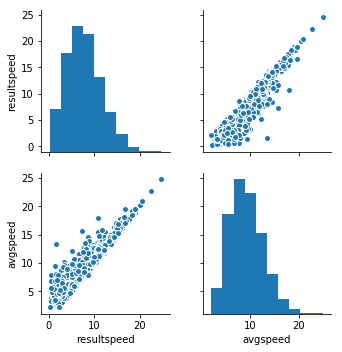

In [387]:
# Station 19 : resultspeed, avgspeed
cols = ["resultspeed", "avgspeed"]
sns.pairplot(station_19[cols])
plt.show()

In [389]:
remove_columns(station_19 , columns = ['station_nbr' , 'date' , 'codesum'])

제거한 컬럼명 : ['station_nbr', 'date', 'codesum']


,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
1030,75.0,52.0,64.0,52.0,57.0,1.0,0.0,0.0,0.04,28.87,29.64,10.0,19.0,11.1
1031,67.0,48.0,58.0,38.0,47.0,7.0,0.0,0.0,0.00,29.08,29.80,14.2,26.0,14.6
1032,49.0,36.0,43.0,32.0,40.0,22.0,0.0,0.0,0.00,29.32,30.04,9.6,30.0,10.1
1033,51.0,32.0,42.0,33.0,40.0,23.0,0.0,0.0,0.00,29.31,30.08,5.5,27.0,6.0
1034,45.0,33.0,39.0,24.0,32.0,26.0,0.0,0.1,0.02,29.51,30.24,20.4,34.0,20.9


In [391]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(station_19.values, i) for i in range(station_19.shape[1])]
vif["features"] = station_19.columns
vif.sort_values('VIF Factor').reset_index(drop = True)

,VIF Factor,features
0,1.137218,snowfall
1,1.245713,preciptotal
2,1.330984,resultdir
3,7.736964,resultspeed
4,8.132752,avgspeed
5,74.953820,stnpressure
6,80.128257,sealevel
7,154.122440,dewpoint
8,234.882038,cool
9,529.244276,wetbulb


In [365]:
# Station 20 
station_20 = getSpecifiedWeatherData(weather, station_nbr=20)
isThereNoneData(station_20, percentage=60)

M Data over 60% : ['depart']
T Data over 60% : []
B Data over 60% : ['sunrise', 'sunset']


,Column,Row Count,Missing Data,M Data %,Trace Data,T Data %,Bar Data,B Data %
0,station_nbr,1035,0,0.00,0,0.00,0,0.0
1,date,1035,0,0.00,0,0.00,0,0.0
2,tmax,1035,2,0.19,0,0.00,0,0.0
3,tmin,1035,4,0.39,0,0.00,0,0.0
4,tavg,1035,7,0.68,0,0.00,0,0.0
5,depart,1035,1035,100.00,0,0.00,0,0.0
6,dewpoint,1035,6,0.58,0,0.00,0,0.0
7,wetbulb,1035,19,1.84,0,0.00,0,0.0
8,heat,1035,7,0.68,0,0.00,0,0.0
9,cool,1035,7,0.68,0,0.00,0,0.0


In [366]:
remove_columns(station_20 , columns= ['depart' , 'sunrise' , 'sunset'])

제거한 컬럼명 : ['depart', 'sunrise', 'sunset']


,station_nbr,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
1030,20,2014-10-27,85,66,76,59,65,0,11,,0.0,0.00,29.11,29.82,10.0,18,10.4
1031,20,2014-10-28,80,68,74,60,65,0,9,,0.0,0.00,29.30,29.97,3.1,36,6.4
1032,20,2014-10-29,78,55,67,47,56,0,2,,0.0,0.00,29.42,30.12,4.9,06,6.1
1033,20,2014-10-30,80,52,66,50,57,0,1,,0.0,0.00,29.40,30.11,1.6,14,4.9
1034,20,2014-10-31,68,50,59,39,50,6,0,,0.0,0.00,29.57,30.27,10.5,36,11.2


In [367]:
station_20 = remove_m_row(station_20)

원본 데이터프레임 length : 1035
제거하고 싶은 컬럼 : ['station_nbr', 'date', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool', 'codesum', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
제거한 int 컬럼 : ['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool']
제거한 float 컬럼 : ['snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
제거한 후 데이터프레임 length : 982


In [368]:
station_20.tail()

,station_nbr,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
1030,20,2014-10-27,85.0,66.0,76.0,59.0,65.0,0.0,11.0,,0.0,0.0,29.11,29.82,10.0,18.0,10.4
1031,20,2014-10-28,80.0,68.0,74.0,60.0,65.0,0.0,9.0,,0.0,0.0,29.30,29.97,3.1,36.0,6.4
1032,20,2014-10-29,78.0,55.0,67.0,47.0,56.0,0.0,2.0,,0.0,0.0,29.42,30.12,4.9,6.0,6.1
1033,20,2014-10-30,80.0,52.0,66.0,50.0,57.0,0.0,1.0,,0.0,0.0,29.40,30.11,1.6,14.0,4.9
1034,20,2014-10-31,68.0,50.0,59.0,39.0,50.0,6.0,0.0,,0.0,0.0,29.57,30.27,10.5,36.0,11.2


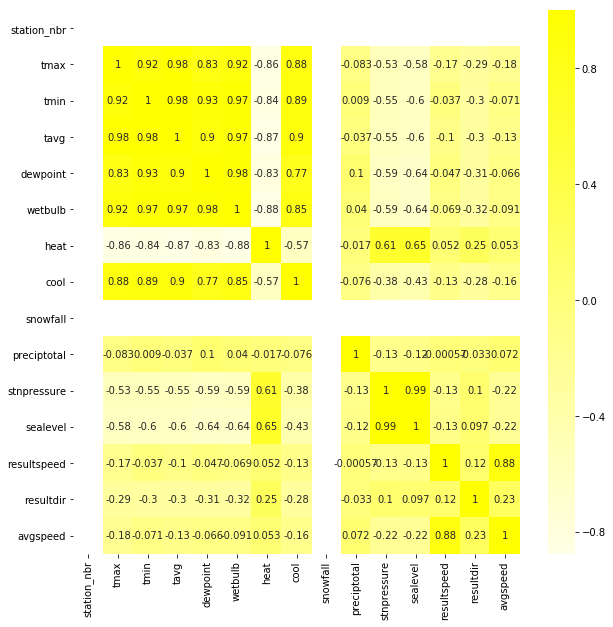

In [370]:
# heatmap 
cols = station_20.columns
plt.figure(figsize = (10,10))
cmap = sns.light_palette("yellow", as_cmap=True) # 위에 한번만 선언하면 됨
sns.heatmap(station_20[cols].corr(), annot=True, cmap=cmap)
plt.show()

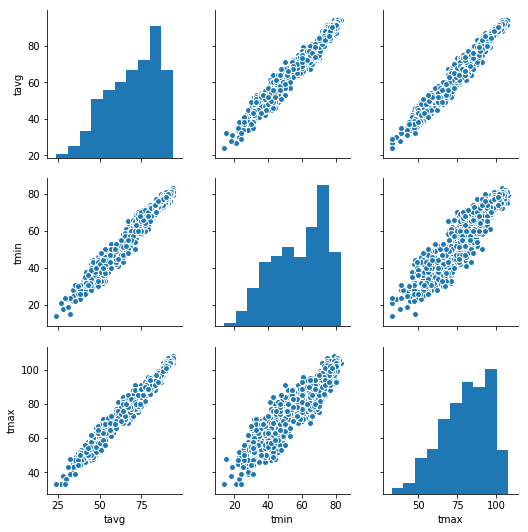

In [371]:
# Station 20 : tmax, tmin, tavg, depart
cols = ["tavg", "tmin", "tmax"]
sns.pairplot(station_20[cols])
plt.show()

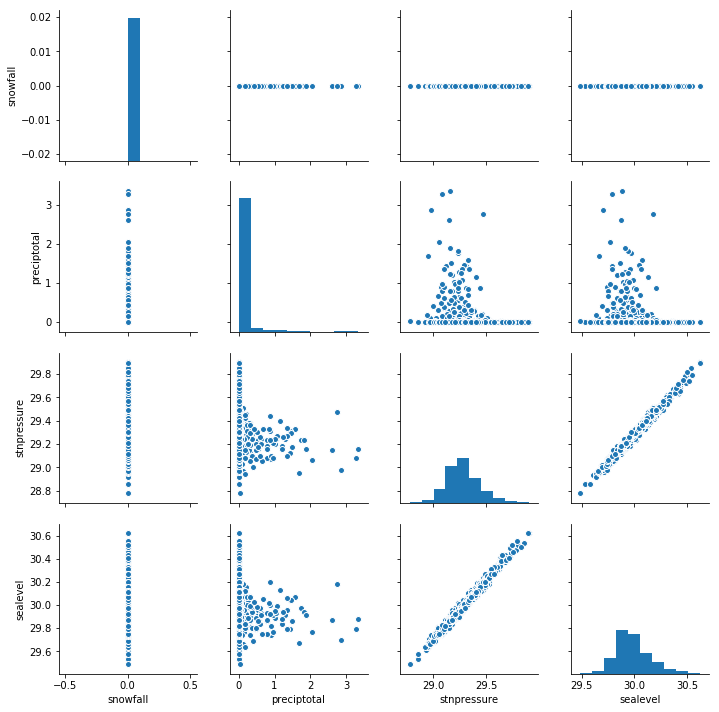

In [372]:
# Station 20 : snowfall, preciptotal, stnpressure, sealevel
cols = ["snowfall", "preciptotal", "stnpressure", "sealevel"]
sns.pairplot(station_20[cols])
plt.show()

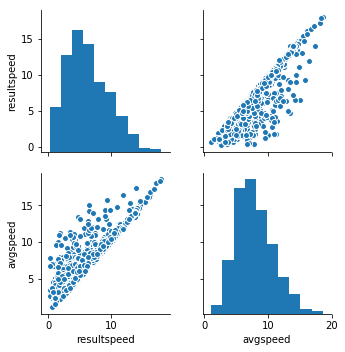

In [373]:
# Station 20 : resultspeed , avgspeed
cols = ["resultspeed", "avgspeed"]
sns.pairplot(station_20[cols])
plt.show()

In [375]:
# remove station number and codesum 
remove_columns(station_20 , columns= ['station_nbr', 'codesum' , 'date'])


제거한 컬럼명 : ['station_nbr', 'codesum']


,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
1030,2014-10-27,85.0,66.0,76.0,59.0,65.0,0.0,11.0,0.0,0.0,29.11,29.82,10.0,18.0,10.4
1031,2014-10-28,80.0,68.0,74.0,60.0,65.0,0.0,9.0,0.0,0.0,29.30,29.97,3.1,36.0,6.4
1032,2014-10-29,78.0,55.0,67.0,47.0,56.0,0.0,2.0,0.0,0.0,29.42,30.12,4.9,6.0,6.1
1033,2014-10-30,80.0,52.0,66.0,50.0,57.0,0.0,1.0,0.0,0.0,29.40,30.11,1.6,14.0,4.9
1034,2014-10-31,68.0,50.0,59.0,39.0,50.0,6.0,0.0,0.0,0.0,29.57,30.27,10.5,36.0,11.2


In [379]:
station_20.head()

,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,59.0,41.0,50.0,28.0,40.0,15.0,0.0,0.0,0.0,29.78,30.48,10.9,33.0,10.8
1,53.0,33.0,43.0,21.0,35.0,22.0,0.0,0.0,0.0,29.90,30.62,7.9,34.0,8.6
2,59.0,30.0,45.0,23.0,37.0,20.0,0.0,0.0,0.0,29.63,30.41,7.9,17.0,8.5
3,62.0,38.0,50.0,32.0,41.0,15.0,0.0,0.0,0.0,29.54,30.27,1.1,32.0,4.9
4,67.0,36.0,52.0,33.0,43.0,13.0,0.0,0.0,0.0,29.46,30.21,2.1,23.0,4.4


In [395]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(station_20.values, i) for i in range(station_20.shape[1])]
vif["features"] = station_20.columns
vif.sort_values('VIF Factor').reset_index(drop = True)

,VIF Factor,features
0,1.167464,preciptotal
1,1.277395,resultdir
2,5.876951,resultspeed
3,6.571229,avgspeed
4,73.165128,dewpoint
5,107.633167,stnpressure
6,122.586510,sealevel
7,222.092910,wetbulb
8,1005.828199,tmax
9,1039.004225,tmin


In [396]:
weather.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,,0.0,0.00,29.95,30.47,14.0,36,13.8
